In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files

# Adım 1: Veri setini yükleme
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

Saving Steel_industry_data.csv to Steel_industry_data.csv


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [4]:
# Adım 2: Tarih-saat sütununu datetime formatına çevirme ve sıralama
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df = df.sort_values('date')


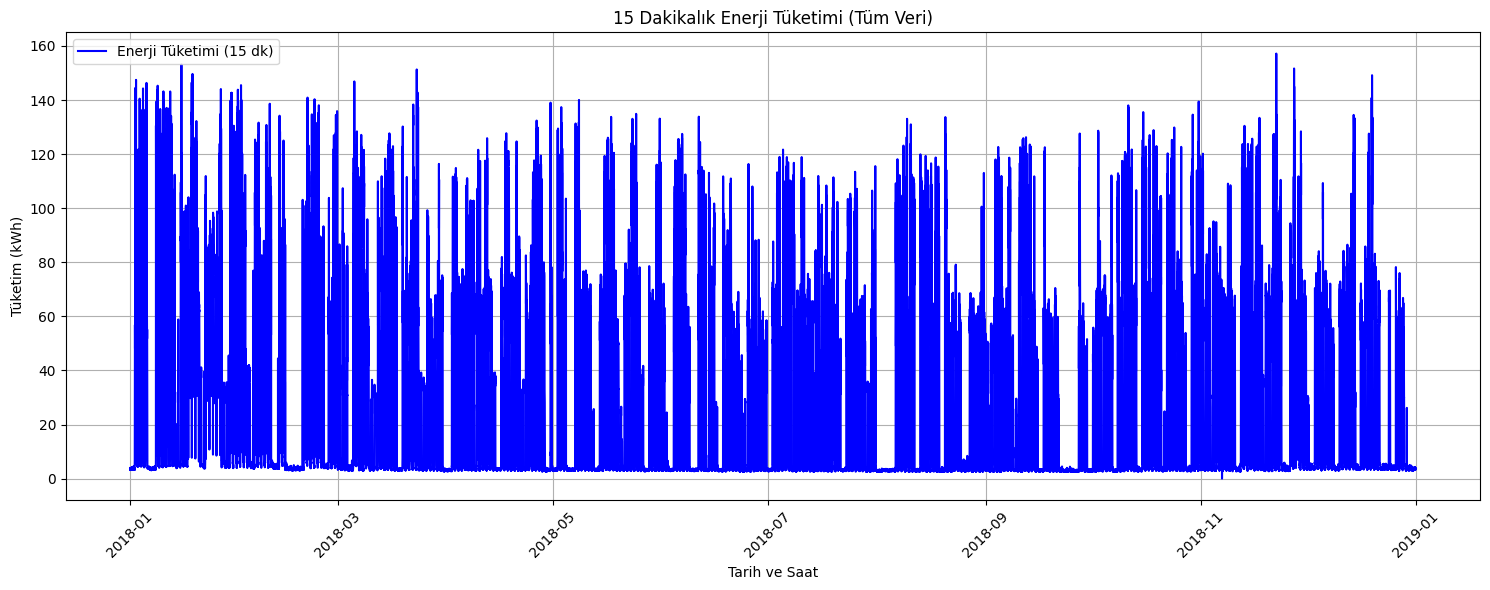

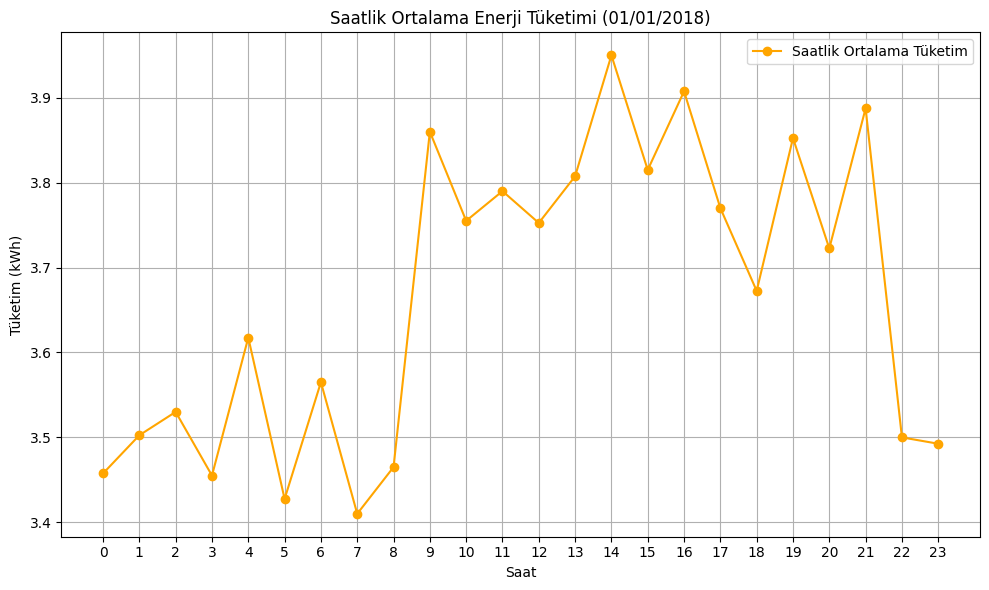

In [5]:
# Adım 3: Enerji tüketim grafikleri (peak noktalarını görmek için)
# 15 dakikalık enerji tüketim grafiği (tüm veri)
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['Usage_kWh'], label='Enerji Tüketimi (15 dk)', color='blue')
plt.xlabel('Tarih ve Saat')
plt.ylabel('Tüketim (kWh)')
plt.title('15 Dakikalık Enerji Tüketimi (Tüm Veri)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saatlik ortalama enerji tüketimi (örnek bir gün için: 01/01/2018)
sample_day = df[df['date'].dt.date == pd.to_datetime('01/01/2018').date()]
hourly_avg = sample_day.groupby(sample_day['date'].dt.hour)['Usage_kWh'].mean()
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, label='Saatlik Ortalama Tüketim', color='orange', marker='o')
plt.xlabel('Saat')
plt.ylabel('Tüketim (kWh)')
plt.title('Saatlik Ortalama Enerji Tüketimi (01/01/2018)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [6]:
# Adım 4: Peak noktalarını tespit etme ve is_peak sütunu ekleme
# Eşik değer: 75 kWh (grafiklere göre ayarlanabilir)
df['is_peak'] = (df['Usage_kWh'] >= 75).astype(int)

# Peak noktalarının Load_Type ve WeekStatus ile ilişkisini analiz etme
print("Peak Noktalarının Load_Type Dağılımı:")
print(df[df['is_peak'] == 1]['Load_Type'].value_counts())
print("\nPeak Noktalarının WeekStatus Dağılımı:")
print(df[df['is_peak'] == 1]['WeekStatus'].value_counts())


Peak Noktalarının Load_Type Dağılımı:
Load_Type
Maximum_Load    1839
Medium_Load     1562
Light_Load       409
Name: count, dtype: int64

Peak Noktalarının WeekStatus Dağılımı:
WeekStatus
Weekday    3516
Weekend     294
Name: count, dtype: int64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35040 non-null  datetime64[ns]
 1   Usage_kWh                             35040 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64       
 4   CO2(tCO2)                             35040 non-null  float64       
 5   Lagging_Current_Power_Factor          35040 non-null  float64       
 6   Leading_Current_Power_Factor          35040 non-null  float64       
 7   NSM                                   35040 non-null  int64         
 8   is_peak                               35040 non-null  int64         
 9   hour                                  35040 non-null  int32         
 10  da

In [9]:
# Adım 5: Zamanla ilgili ek özellikler çıkarma
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month


In [14]:
# Adım 6: Kategorik değişkenleri one-hot encoding ile kodlama
df = pd.get_dummies(df, columns=['Load_Type', 'WeekStatus', 'Day_of_week'], drop_first=True)


KeyError: "None of [Index(['Load_Type', 'WeekStatus', 'Day_of_week'], dtype='object')] are in the [columns]"

In [ ]:
# Adım 7: Bool sütunları int'e çevirme
features = ['Usage_kWh', 'hour', 'day', 'month', 'NSM', 'is_peak'] + \
          [col for col in df.columns if 'Load_Type_' in col or 'WeekStatus_' in col or 'Day_of_week_' in col]
data = df[features]
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)
print("\nVeri Tipleri (Bool'dan Int'e Çevrildikten Sonra):")
print(data.info())


Veri Tipleri (Bool'dan Int'e Çevrildikten Sonra):
<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Usage_kWh               35040 non-null  float64
 1   hour                    35040 non-null  int32  
 2   day                     35040 non-null  int32  
 3   month                   35040 non-null  int32  
 4   NSM                     35040 non-null  int64  
 5   is_peak                 35040 non-null  int64  
 6   Load_Type_Maximum_Load  35040 non-null  int64  
 7   Load_Type_Medium_Load   35040 non-null  int64  
 8   WeekStatus_Weekend      35040 non-null  int64  
 9   Day_of_week_Monday      35040 non-null  int64  
 10  Day_of_week_Saturday    35040 non-null  int64  
 11  Day_of_week_Sunday      35040 non-null  int64  
 12  Day_of_week_Thursday    35040 non-null  int64  
 13  Day_of_week_Tuesday     35040 non-null  int6

<ipython-input-27-5af1954a9006>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[bool_cols] = data[bool_cols].astype(int)


In [ ]:
# Adım 8: Ayrı bir scaler ile sadece Usage_kWh için normalizasyon
usage_scaler = MinMaxScaler()
usage_scaled = usage_scaler.fit_transform(data[['Usage_kWh']])

In [ ]:
# Adım 9: Tüm veriyi ölçeklendirme (normalizasyon)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
# Adım 10: Zaman serisi penceresi oluşturma fonksiyonu
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [ ]:
# Adım 11: Pencereleme ve veri hazırlığı (48 saatlik geçmiş)
sequence_length = 192  # 48 saat (15 dakikada 1 ölçüm, 48*4=192)
X, y = create_sequences(scaled_data, sequence_length)


In [ ]:
# Adım 12: Eğitim ve test setine ayırma
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Adım 13: Daha karmaşık bir LSTM modeli oluşturma
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, len(features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Adım 14: Early Stopping ve ReduceLROnPlateau callback'lerini tanımlama
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [ ]:
# Adım 15: Modeli eğitme
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1,
                    callbacks=[early_stopping, reduce_lr], verbose=1)


In [ ]:
# Adım 16: Tahmin yapma
y_pred = model.predict(X_test)


In [ ]:
# Adım 17: Normalizasyonu geri alma (sadece Usage_kWh için)
y_test_original = usage_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = usage_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [ ]:
# Adım 18: Model değerlendirme (MSE ve R² skoru)
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
print(f"Mean Squared Error: {mse}")
print(f"R² Skoru: {r2:.4f}")

In [ ]:

# Adım 19: Saatlik tahminler için veriyi gruplama
hourly_df = df.iloc[train_size:].groupby([df['date'].dt.date[train_size:], df['hour'][train_size:]])['Usage_kWh'].mean().reset_index()
hourly_actual = hourly_df.tail(24)['Usage_kWh'].values

In [ ]:
# Adım 20: 24 saatlik tahmin
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, len(features))
next_96_pred = []
for _ in range(96):
    pred = model.predict(last_sequence)[0, 0]
    next_96_pred.append(pred)
    new_row = last_sequence[0, -1].copy()
    new_row[0] = pred
    new_row[1] = (new_row[1] + 0.25) % 24
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1] = new_row


In [ ]:
# Adım 21: 24 saatlik tahmin için normalizasyonu geri alma
next_96_pred_original = usage_scaler.inverse_transform(np.array(next_96_pred).reshape(-1, 1)).flatten()

In [ ]:
# Adım 22: Saatlik ortalamaları hesaplama ve sonuçları yazdırma
hourly_pred = [next_96_pred_original[i:i+4].mean() for i in range(0, 96, 4)]
print(f"24 Saatlik Toplam Tahmin: {sum(hourly_pred):.2f} kWh")
print("Saatlik Tahminler:")
for hour, pred in enumerate(hourly_pred):
    print(f"Saat {hour:02d}:00 - {pred:.2f} kWh")


In [ ]:
# Adım 23: Görselleştirme - 15 dakikalık tahmin grafiği
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:96], label='Gerçek Değerler (15 dk)')
plt.plot(y_pred_original[:96], label='Tahminler (15 dk)')
plt.xlabel('Zaman (15 dakikalık aralıklar)')
plt.ylabel('Tüketim (kWh)')
plt.title('Gerçek vs Tahmin Edilen Tüketim (15 dakikalık)')
plt.legend()
plt.show()


In [ ]:
# Adım 24: Görselleştirme - Saatlik tahmin grafiği
plt.figure(figsize=(12, 6))
plt.plot(range(24), hourly_actual, label='Gerçek Saatlik Ortalama (Son 24 saat)')
plt.plot(range(24), hourly_pred, label='Tahmin Edilen Saatlik Ortalama')
plt.xlabel('Saat')
plt.ylabel('Tüketim (kWh)')
plt.title('Saatlik Gerçek vs Tahmin Edilen Tüketim')
plt.legend()
plt.show()

In [ ]:
# Adım 25: Görselleştirme - Eğitim sürecindeki kayıp grafiği
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (MSE)')
plt.title('Eğitim Sürecindeki Kayıp')
plt.legend()